<a id="Table"></a>
# Stomata detection using Faster RCNN

Table of Contents:
* [Part 1: Introduction and Setup](#Intro)
* [Part 2: Dataset class setup](#Dataset)
* [Part 3: Model configuration](#Model)
* [Part 4: Image visulisation](#Image-visual)
* [Part 5: K-fold cross validation](#K-fold)
* [Part 6: Final training and evaluation](#Final-train)
* [Part 7: Inference](#Inference)
* [Part 8: Summary](#Summary)

<a id="Intro"></a>
# Part 1: Introduction and Setup

Base resource can be found [**here**](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).
The project that helped me a lot can be found [**here**](https://www.kaggle.com/code/benmanor/crater-object-detection-using-faster-rcnn)

**The first step was installing the necessary packages:**
* Helper functions for the torchvision package were cloned from pytorch repo.
* Pycocotools contains the modules needed by torchvision helper functions to train and evaluate models pretrained on COCO dataset.
* Albumentations were istalled to enable image augmentations while correcting bounding boxes coordinates.
* Open-cv was installed for image editing and display, despite running into incompatiblity issues as will be detailed in later sections.
* The images and annotations(bounding box coordinates) of train and validation datasets were unified to enable easier implementation of training cross validation.

**Importing the libraries:**
Beside the common libraries such as os,torch, matplotlib etc. helper functions such as "train_one_epoch" for training and "Tranforms" for transformations on the image dataset were imported as well.
Finally, Kfold was imported from sklearn to enable cross validation on the data as will be discussed farther.

In [1]:
# Download TorchVision repo to use some files from
# references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.8.2

# !cp ./vision/references/detection/utils.py ./
# !cp ./vision/references/detection/transforms.py ./
# !cp ./vision/references/detection/coco_eval.py ./
# !cp ./vision/references/detection/engine.py ./
# !cp ./vision/references/detection/coco_utils.py ./

# !pip install cython
# # Install pycocotools, the version by default in Colab
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !pip install -U albumentations
# !pip install -U opencv-python

# #Copy and unify the train and validation datasets into one folder for images and another for labels
# !mkdir ./train
# !cp -a craters/train/images/. ./train/images/
# !cp -a craters/valid/images/. ./train/images/
# !cp -a craters/train/labels/. ./train/labels/
# !cp -a craters/valid/labels/. ./train/labels/

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

<a id="Dataset"></a>
# Part 2: Dataset class setup

The following code defines the Dataset class.
The contructor defines the transformations to be performed on the data and image and boundry boxes locations as well as class names are defined.
The pretrained models as imported from the torchvision library requires the class to contain
a __getitem__ method to rerieve indvidual images and boxes as well as __len__ method to return number of images in data set.

In __getitem__ I have added syntex to convert the box coordinates from the (normalized x,y,w,h) format to the required (xmin,ymin,xmax,ymax) by the model, using **convert_box_cord** method. I have also added a condition to create a dummy box object with class 0(background) because importing empty .txt files for some of the images raised errors.

Finally the "target" library was populated with the their required keys i.e. boundry boxes, labels etc.

In [2]:
class StomataDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Stomata']
        
    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 1224, 1224]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 1224, 1224]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)



<a id="Model"></a>
# Part 3: Model Configuration

For this project Faster RCNN with a resnet50 backbone pre-trained on COCO dataset was loaded.
the ROI pre-trained head was replaced with an untrained head to be trained on our dataset.

Different backones were tested such as mobilenet_v3_large_fpn and  resnet50_fpn_v2 which was finally selected.
However, I was unable to upgrade the torchvision version from 0.12 > 0.13 which containes the updated backbone on the kaggle platform so I reverted to using v1 for this notebook.

**get_transform** function defines the augmentations to be implemented on the dataset before being passes to the model.
I have opted to change the augmentation methods used from the default torchvision provided to albumentation.
The main reason being that using torchvision augmentation as is, requires customization of each transform method to be able to adjust the box coordinates accordingly, whereas albumentation does that automatically. Note that no augmentation is enabled in the code below as counter intuitively no augmentations demonstrated better scores in the validation stage as will be discussed.
If augmentation is applied though, a **min_visibility** attribute is recommeded to define the cutoff threshold for ignoring a boundry box if it's remaining area ratio to original area on the augmented product is less the value set.

The reset_weights function resets all trainable weights in the model.
A short attempt was made to do so but considerable time and larger dataset will be required to improve on the pre trained model.


In [3]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

In [4]:
def get_model_bbox(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True, weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [6]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

<a id="Image-visual"></a>
# Part 4: Image visualization 

The following function displays an image recieved from the dataset and overlays the boundry boxes from the annotation file

In [7]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Stomata', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

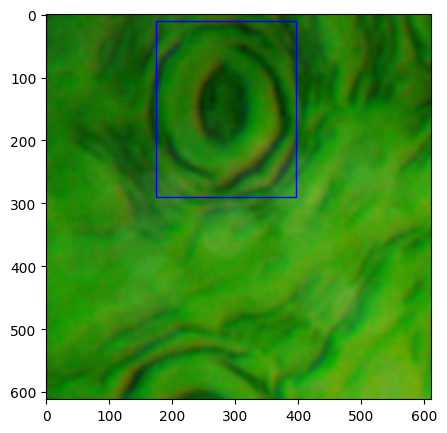

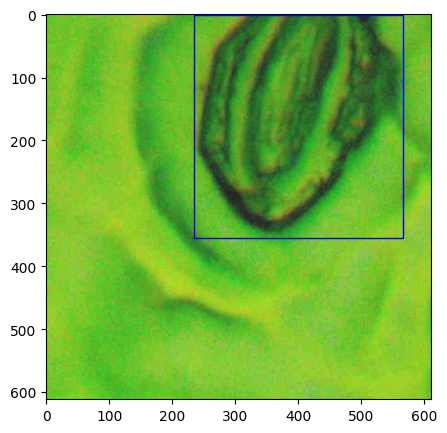

In [8]:
dataset = StomataDataset('../Dataset/all_images/val/', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, len(dataset)), 2):
    img, target = dataset[i]
    plot_img_bbox(img, target)

<a id="K-fold"></a>
# Part 5: K-fold cross validation

One of the drawbacks of a small database is that it's problematic to rely on the evaluation of the trained model on the validation dataset either selected manually or randomly.
The issue is that it's hard to estimate if the validation dataset that was selected is biased towards or against the training dataset. statistically with a large database that is less likely to happen but with our database it's hard to guarantee. 

For this reason I chose to perform K-fold validation with 5 folds, which will randomly split the dataset(train and validation) 5 times, each time training 50 epochs and average the resulting metrics from each fold, raising the confidence that a certain setup hyperparamters and configurations are advantageous or not.

Over 14 diffrent configurations of optimizers, augmentations, batch sizes and freezing different layers were attempted.
The following table summerises the 8 best configurations tested using K-fold cross validation.
The performance was rated according to two popular COCO metrics: mAP @ IoU:0.5 and mAP@IoU:0.5:0.95


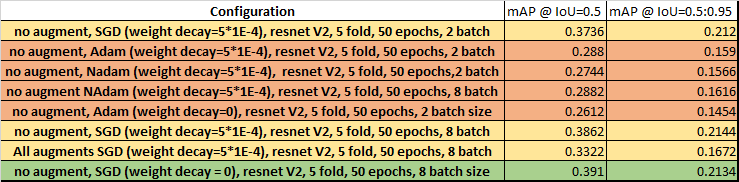


In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
k_folds = 5
num_epochs = 5


# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = StomataDataset('dataset/images/train', get_transform(train=True))
dataset_val = StomataDataset('dataset/images/val', get_transform(train=False))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=8, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)
    
    #model.apply(reset_weights) # Check if beneficial
    
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,  # Check if beneficial
                                momentum=0.9, weight_decay=0.005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10)
    
    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader, device=device)

    # print(len(data_loader_val))

<a id="Final-train"></a>
# Part 6: Final training and evaluation



In the final training the selected model configuration was run for 200 epochs on the combined train and validation datasets, saving the best score metric of mAP@IoU:0.5 on each epoch. 
Due to the small size of 19 images selected for testing, which may well be biased in some manner, the best scoring epoch was achieved in the first few epochs. After which thetrain loss metric continued to improve but the evaluation metrics on the test dataset got worse.

In [10]:
import csv, datetime, os

# open the file in the write mode

def make_stat_directory(algoritm_name):
    curr_time = datetime.datetime.now().strftime("%d-%m-%Y-%H:%M")

    new_folder_root = f"./output/{algoritm_name}/{algoritm_name}-{curr_time}"

    # make file diretory if not exists 
    os.makedirs(new_folder_root, exist_ok=True)

    return new_folder_root


# get complete filepath of the csv file to apeend the training metrices 
def create_csv(rootfolder, csv_filename):
    """ This function creates a csv file """
    csv_com_filepath = os.path.join(rootfolder, csv_filename)
    
    csv_headings = [
        "Epoch","Learning Rate", "Training Loss", "Classification Loss", 
        "Box Loss","MAP50","MAP95", "Recall"
        ]
    with open(csv_com_filepath, 'w') as f:
        # create the csv writer
        writer = csv.writer(f)

        # write the header to the csv file
        writer.writerow(csv_headings)
    
    return csv_com_filepath

def append_metrices(writer, data):

    """ This function requires a dictionary structured exactly what is given below """

    #     data = {
    #     "epoch": epoch,
    #     "learning_rate": learn_r, 
    #     "training_loss": tr_loss, 
    #     "classification_loss": class_loss, 
    #     "box_loss": bbox_loss,
    #     "precision_map50": precision_map50, 
    #     "precision_map95": precision_map50_95, 
    #     "recall_map95": recall_map50_95

    writer.writerow(list(data.values()))

In [11]:
num_epochs = 150

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
# dataset = StomataDataset('../Dataset/all_images/train', get_transform(train=True))
# dataset_test = StomataDataset('../Dataset/all_images/val', get_transform(train=False))

dataset = StomataDataset('../Dataset/all_images/train/', get_transform(train=True))
dataset_test = StomataDataset('../Dataset/all_images/val/', get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [12]:
len(dataset)

14112

In [ ]:
# get the model using our helper function
model = get_model_bbox(num_classes)

'''
Use this to reset all trainable weights
model.apply(reset_weights)
'''

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,  # Feel free to play with values
                            momentum=0.9, weight_decay=0.005)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.1)

result_mAP = []
best_epoch = None

""" lets create and open a directory and a csv file to store the resulting matrices  """
# call function to create csv file

algoritm_name = "FRCNN" # Faster RCNN
curr_time = datetime.datetime.now().strftime("%d-%m-%Y-%H:%M")
csv_newfile_name = f"{algoritm_name}-{curr_time}.csv"

# create and get the dir name 
output_root = make_stat_directory(algoritm_name)

# create a csv file
csv_com_filepath = create_csv(output_root, csv_filename=csv_newfile_name)

""" Let's train our algorithm! """ 
for epoch in range(num_epochs):

    # train for one epoch, printing every 10 iterations
    epoch_statistic = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=300)

    # update the learning rate
    lr_scheduler.step()

    # global averages of training parameters
    learn_r, tr_loss, class_loss, bbox_loss =   epoch_statistic.meters["lr"].global_avg, epoch_statistic.meters["loss"].global_avg, \
                                                epoch_statistic.meters["classification"].global_avg, epoch_statistic.meters["bbox_regression"].global_avg

    # evaluate on the test dataset
    results =  evaluate(model, data_loader_test, device=device)

    precision_map50_95, precision_map50, recall_map50_95 = results.coco_eval['bbox'].stats[0], results.coco_eval['bbox'].stats[1], \
                                                            results.coco_eval['bbox'].stats[8]

    # metrices per epoch 
    epoch_matrices = {
        "epoch": epoch,
        "learning_rate": learn_r, 
        "training_loss": tr_loss, 
        "classification_loss": class_loss, 
        "box_loss": bbox_loss,
        "precision_map50": precision_map50, 
        "precision_map95": precision_map50_95, 
        "recall_map95": recall_map50_95
    }

    # open csv file 
    csv_file_handler = open(csv_com_filepath, 'a')
    # define writer 
    writer = csv.writer(csv_file_handler)
    append_metrices(writer=writer, data=epoch_matrices)

    # close the csv file that stores the training stats 
    csv_file_handler.close()

    # saves results of mAP @ IoU = 0.5
    result_mAP.append(results.coco_eval['bbox'].stats[1])
    
    #save the best model so far every 5 epoch
    if epoch % 5 == 0:
        if result_mAP[-1] == max(result_mAP):
            best_save_path = os.path.join(f'{output_root}/{algoritm_name}-epoch{epoch}.pth')
            torch.save(model.state_dict(), best_save_path)
            best_epoch = int(epoch)
            print(f'\n\nmodel from epoch number {epoch} saved!\n result is {max(result_mAP)}\n\n')

# Saving the last model
save_path = os.path.join(f'{output_root}/{algoritm_name}-epoch{epoch}.pth')
torch.save(model.state_dict(), save_path)

print(f'model from last epoch(no.{num_epochs-1}) saved')

<a id="Inference"></a>
# Part 7: Inference

Finally, the best performing model on the test dataset is loaded and inference is perfomed here to display and save the images with the original labeling and the predicions of the model with the confidence threshhold set to 0.5.

Also, the fps for predictions and writing files is calculated




In [ ]:
dataset_test = StomataDataset('dataset/images/val', get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

model = get_model_bbox(num_classes)

# load model to evaluate
model.load_state_dict(torch.load(os.path.join(f'Crater_bestmodel_noaug_sgd(wd=0)_8batch-epoch{best_epoch}.pth'),map_location=device))
model.to(device)

evaluate(model, data_loader_test, device=device)

In [ ]:
# Define colors for bounding boxes
color_inference = np.array([0.0,0.0,255.0])
color_label = np.array([255.0,0.0,0.0])

# Score value thershold for displaying predictions
detection_threshold = 0.5
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

!mkdir ./results

In [ ]:
for i,data in enumerate(data_loader_test):
    # get the image file name for predictions file name
    image_name = 'image no:' + str(int(data[1][0]['image_id']))
    model_image = data[0][0]
    cv2_image = np.transpose(model_image.numpy()*255,(1, 2, 0)).astype(np.float32)
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR).astype(np.float32)

    # add batch dimension
    model_image = torch.unsqueeze(model_image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(model_image.to(device))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there's detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = np.round(scores[scores >= detection_threshold],2)
        draw_boxes = boxes.copy()


        # draw the bounding boxes and write the class name on top of it
        for j,box in enumerate(draw_boxes):
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_inference, 2)
            cv2.putText(img=cv2_image, text="Crater",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)
            cv2.putText(img=cv2_image, text=str(scores[j]),
                        org=(int(box[0]), int(box[1] + 8)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_inference,
                        thickness=1, lineType=cv2.LINE_AA)
            
        # add boxes for labels
        for box in data[1][0]['boxes']:
            cv2.rectangle(cv2_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          color_label, 2)
            cv2.putText(img=cv2_image, text="Label",
                        org=(int(box[0]), int(box[1] - 5)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale= 0.3,color= color_label,
                        thickness=1, lineType=cv2.LINE_AA)           
            

        # set size
        plt.figure(figsize=(10,10))
        plt.axis("off")

        # convert color from CV2 BGR back to RGB
        plt_image = cv2.cvtColor(cv2_image/255.0, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
        plt.show()
        cv2.imwrite(f"./results/{image_name}.jpg", cv2_image)
    print(f"Image {i + 1} done...")
    print('-' * 50)
print('TEST PREDICTIONS COMPLETE')

avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


<a id="Summary"></a>
# Part 8: Summary

In summary, there is definatly more work to be done on this project: 
* First and foremost the database needs to be expanded and validation of the labeling should be performed by a third party.
* Secondly, the model should be configured with diffrent backbones and augmenations combinations to try and achieve better metrics.
* lastly the hyperparamters of the model should be fine tuned to get the optimal gradients during training.






**Thank for reading this notebook!**

 If you have any suggestions or comments, please do so in the comment section and upvote if you enjoyed this project.
 
 [**Back to Table of Contents**](#Table)